# Importing neccesary libraries

In [53]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Pre-processing the data

The dataset is taken from [banknote-authentication](https://www.openml.org/search?type=data&sort=runs&id=1462&status=active) dataset provided by Volker Lohweg (University of Applied Sciences, Ostwestfalen-Lippe)

In the dataset we only take 2 features: V1 (Variance of Wavelet Transformed image), V2 (Skewness of Wavelet Transformed image)

In [2]:
dt=pd.read_csv('BankNotes_fulldata.arff')
dt.head()

,V1,V2,V3,V4,Class (target)
0,3.62160,8.6661,-2.8073,-0.44699,1
1,4.54590,8.1674,-2.4586,-1.46210,1
2,3.86600,-2.6383,1.9242,0.10645,1
3,3.45660,9.5228,-4.0112,-3.59440,1
4,0.32924,-4.4552,4.5718,-0.98880,1


In [3]:
truth=dt['Class (target)']
dt.drop('Class (target)', axis=1, inplace=True) #Removing the target column

In [4]:
dt.head()

,V1,V2,V3,V4
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


In [5]:
cols=dt.shape[1] # number of columns
rows=dt.shape[0] # number of rows

In [6]:
#Range of each features

means=[]
stds=[]
for i in range(cols):
    vCol=dt[f'V{i+1}']
    print(f'V{i+1} \n Range: {vCol.max()-vCol.min()}, Mean: {vCol.mean()}, Std: {vCol.std()}')

V1 
 Range: 13.8669, Mean: 0.43373525728862977, Std: 2.8427625862451658
V2 
 Range: 26.7247, Mean: 1.9223531209912539, Std: 5.869046743580378
V3 
 Range: 23.2135, Mean: 1.397627116618076, Std: 4.310030090315984
V4 
 Range: 10.9977, Mean: -1.1916565211370262, Std: 2.1010131367390685


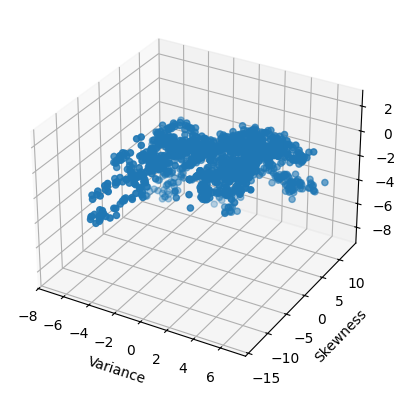

In [7]:
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')


ax.scatter(dt['V1'],dt['V2'],dt['V4'])
ax.set_xlabel('Variance')
ax.set_ylabel('Skewness')
ax.set_zlabel('Entropy')

plt.show()

# Normalization of data

**Min-Max normalization**:

> * $$x' = \frac{\sum_{i=1}^{n} (x_{ij} - x_{min})}{x_{max}-x_{min}} $$


In [8]:
def normalization(arr):
    norm=[] #Create empty restoring place
    cols=len(arr[0])
    for i in range(cols):
        print(f'Col #{i}:', end=' ')
        norm.append((arr[:,i]-arr[:,i].min())/(arr[:,i].max()-arr[:,i].min()))
        print(norm[i])
    return norm

def reshaped(arr):
    col=len(arr)
    row=len(arr[0])
    print(f'Inf {row} rows, {col} cols')
    arr=np.array(arr)
    res=np.array([[None]*col]*row)
    # print(res.shape)
    for i in range(len(arr)):
        res[:,i]=arr[i]
    print(f'Reshaped array: \n', res)
    return res


The input array for K-Means should be a 2D array following this structure: [[*value 0 of col 1*, *value 1 of col 2*], ...,[*value n of col 1*, *value n of col 2*]]. We can see that dt.values already has the correct structure, which is [[*V1[0], V2[0]*],... **V1[n], V2[n]*]*]. So there's no need to reshape it.

In [9]:
taken_data=dt[['V1', 'V2', 'V4']]

In [10]:
#Because, with my norm function it returned the array with shape [[values of col 1],[values of col 2],...,[values of col n]] which is difference from our origin input for K-Means
#With the reshaped function it will transform the data from [[a1, a2, ..., an], [b1, b2, ..., bn]]
#to
# [[a1, b1],
#  [a2, b2],
#  ...
#  [an, bn]]
norm = reshaped(normalization(taken_data.values))

Col #0: [0.76900389 0.83565902 0.78662859 ... 0.23738543 0.25084193 0.32452819]
Col #1: [0.83964273 0.82098209 0.41664827 ... 0.01176814 0.20170105 0.49074676]
Col #2: [0.73662766 0.64432563 0.78695091 ... 0.52475518 0.6606745  0.88594888]
Inf 1372 rows, 3 cols
Reshaped array: 
 [[0.7690038869538253 0.8396427275142472 0.7366276585104158]
 [0.835659015353107 0.8209820877315742 0.6443256317229966]
 [0.7866285903842964 0.41664826920414444 0.78695090791711]
 ...
 [0.23738542861057624 0.011768139586225437 0.5247551760822717]
 [0.25084193294824364 0.20170104809408523 0.660674504669158]
 [0.32452819303521335 0.4907467623584175 0.8859488802204096]]


In [11]:
meansNorm=[]
stdsNorm=[]
for i in range(norm.shape[1]):
    vCol=norm[:,i]
    print(f'Col {i+1} \n Range: {vCol.max()-vCol.min()}, Mean: {vCol.mean()}, Std: {vCol.std()}')


Col 1 
 Range: 1.0, Mean: 0.5391136632764809, Std: 0.2049287443629144
Col 2 
 Range: 1.0, Mean: 0.5873013774145724, Std: 0.21953127587108529
Col 3 
 Range: 1.0, Mean: 0.66891654426498, Std: 0.19097150511731742


Now, we can see that the *ranges, means, and standard deviations* of the two columns are approximately the same! A greate improvement!

* Visualize V1 and V2 scatter plot after normalization

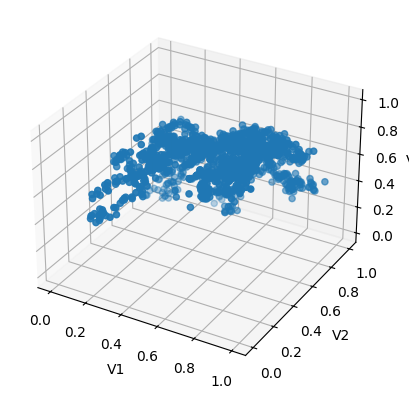

In [12]:
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')


ax.scatter(norm[:,0], norm[:,1],norm[:,2])
ax.set_xlabel('V1')
ax.set_ylabel('V2')
ax.set_zlabel('V4')

plt.show()

In [64]:
testNorm=np.array([norm[:,0], norm[:,1]])
norm=reshaped(testNorm)

Inf 1372 rows, 2 cols
Reshaped array: 
 [[0.7690038869538253 0.8396427275142472]
 [0.835659015353107 0.8209820877315742]
 [0.7866285903842964 0.41664826920414444]
 ...
 [0.23738542861057624 0.011768139586225437]
 [0.25084193294824364 0.20170104809408523]
 [0.32452819303521335 0.4907467623584175]]


In [65]:
#Apply K-means clustering to the normalized data
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
km_res=kmeans.fit(norm)

In [55]:
!pip install  scikit-learn-extra

     -------------------------------------- 340.5/340.5 kB 1.5 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
from sklearn_extra.cluster import KMedoids

scaler=StandardScaler()
scaler_data=scaler.fit_transform(taken_data)
kmeans_z = KMedoids(n_clusters=2, init='k-means++', random_state=42, metric='manhattan')
km_res_z=kmeans.fit(scaler_data)

In here, we are getting a greate result with 4 clusters.

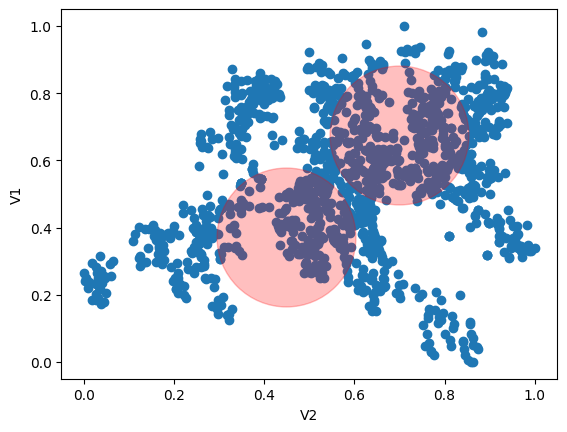

In [66]:
plt.xlabel("V2")
plt.ylabel("V1")

plt.scatter(norm[:,1], norm[:,0])
plt.scatter(km_res.cluster_centers_[:,1], km_res.cluster_centers_[:,0], color='red', s=10000, alpha=0.25)

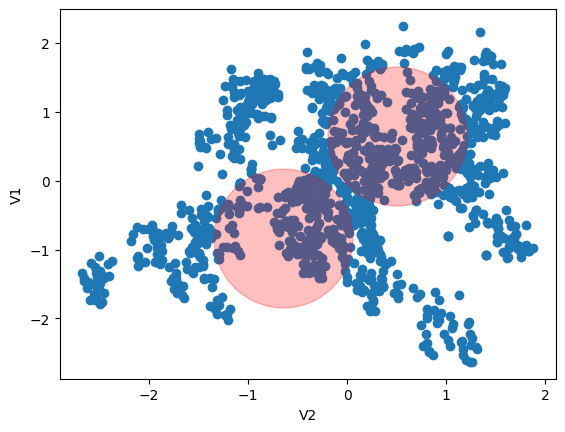

In [57]:
plt.xlabel("V2")
plt.ylabel("V1")

plt.scatter(scaler_data[:,1], scaler_data[:,0])
plt.scatter(km_res_z.cluster_centers_[:,1], km_res_z.cluster_centers_[:,0], color='red', s=10000, alpha=0.25)

From here, I will mark on 4 areas belonging to each cluster. The color represents the cluster label. The yellow point represents the mean of the entire dataset.

In [67]:
labels=km_res.labels_ #Getting the labels of each data point

C:\Users\DELL\AppData\Local\Temp\ipykernel_8680\2948800909.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(dt.iloc[i][1], dt.iloc[i][0], color=colors[labels[i]])


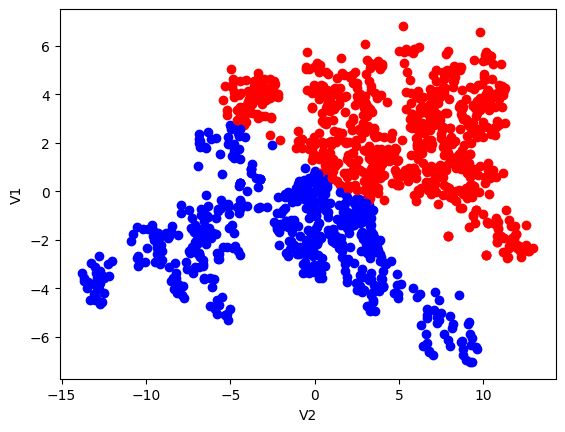

In [68]:
plt.xlabel('V2')
plt.ylabel('V1')
colors=['red','blue','green','pink']
# Loop through each cluster
for i in range(rows):
    plt.scatter(dt.iloc[i][1], dt.iloc[i][0], color=colors[labels[i]])


Z-Score

C:\Users\DELL\AppData\Local\Temp\ipykernel_8680\1297720395.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(dt.iloc[i][1], dt.iloc[i][0], color=colors[labels[i]])


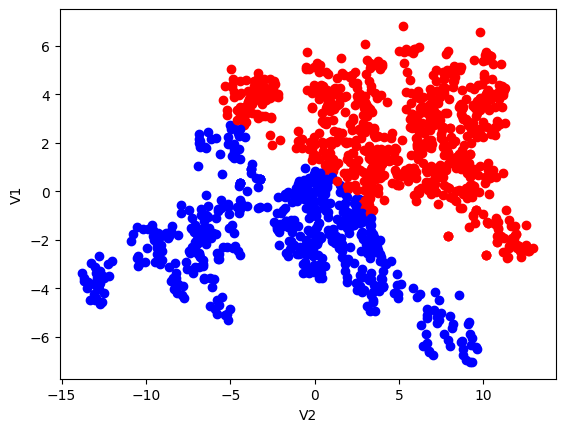

In [58]:
labels=km_res_z.labels_ #Getting the labels of each data point
plt.xlabel('V2')
plt.ylabel('V1')
colors=['red','blue','green','pink']
# Loop through each cluster
for i in range(rows):
    plt.scatter(dt.iloc[i][1], dt.iloc[i][0], color=colors[labels[i]])


C:\Users\DELL\AppData\Local\Temp\ipykernel_8680\2741883166.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(dt.iloc[i][1], dt.iloc[i][0], color=colors[truth[i]-1])


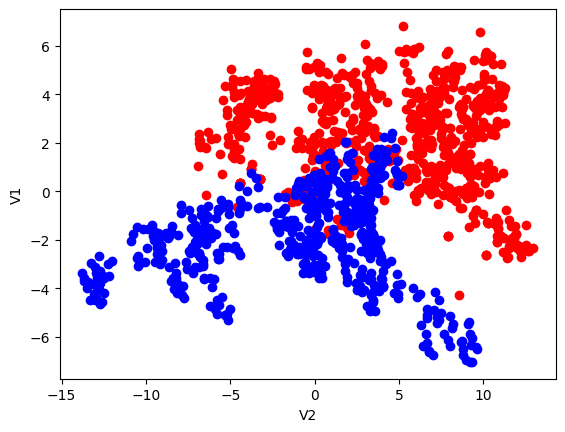

In [38]:
#Compare with truth labels
fig = plt.figure()
ax = fig.add_subplot(111)
colors=['red','blue','green','pink']

ax.set_xlabel('V2')
ax.set_ylabel('V1')
# ax.set_zlabel('Entropy')

for i in range(rows):
    ax.scatter(dt.iloc[i][1], dt.iloc[i][0], color=colors[truth[i]-1])

plt.show()

Min-Max Normalization


C:\Users\DELL\AppData\Local\Temp\ipykernel_8680\1779966418.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(dt.iloc[i][0], dt.iloc[i][1], dt.iloc[i][3], color=colors[labels[i]])


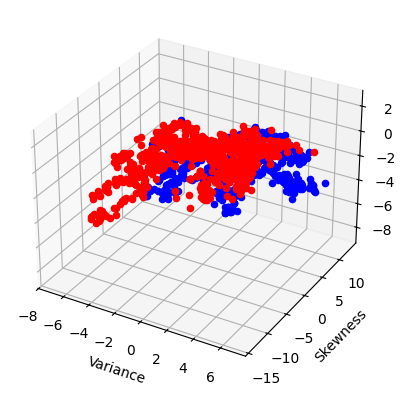

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors=['red','blue','green','pink']

ax.set_xlabel('Variance')
ax.set_ylabel('Skewness')
ax.set_zlabel('Entropy')

for i in range(rows):
    ax.scatter(dt.iloc[i][0], dt.iloc[i][1], dt.iloc[i][3], color=colors[labels[i]])

plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_8680\4228410689.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(dt.iloc[i][0], dt.iloc[i][1], dt.iloc[i][3], color=colors[truth[i]])


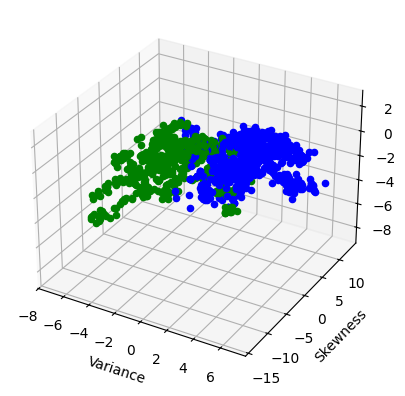

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors=['red','blue','green','pink']

ax.set_xlabel('Variance')
ax.set_ylabel('Skewness')
ax.set_zlabel('Entropy')

for i in range(rows):
    ax.scatter(dt.iloc[i][0], dt.iloc[i][1], dt.iloc[i][3], color=colors[truth[i]])

plt.show()

In [47]:
def accuracy(true_labels, predicted_labels):
    return ((true_labels == predicted_labels+1).sum() / len(true_labels))*100

In [69]:
accuracy(truth, km_res.labels_)

87.17201166180757